In [1]:
import pandas as pd
import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import identify_local_mono
from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_24.hdf5'
dataset_CC18 = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs, dataset_minmaxfs, dataset_standardfs = dataset_CC18[..., 0, 0], dataset_CC18[..., 1, 0], dataset_CC18[..., 2, 0]

learner: 12, dataset: 6


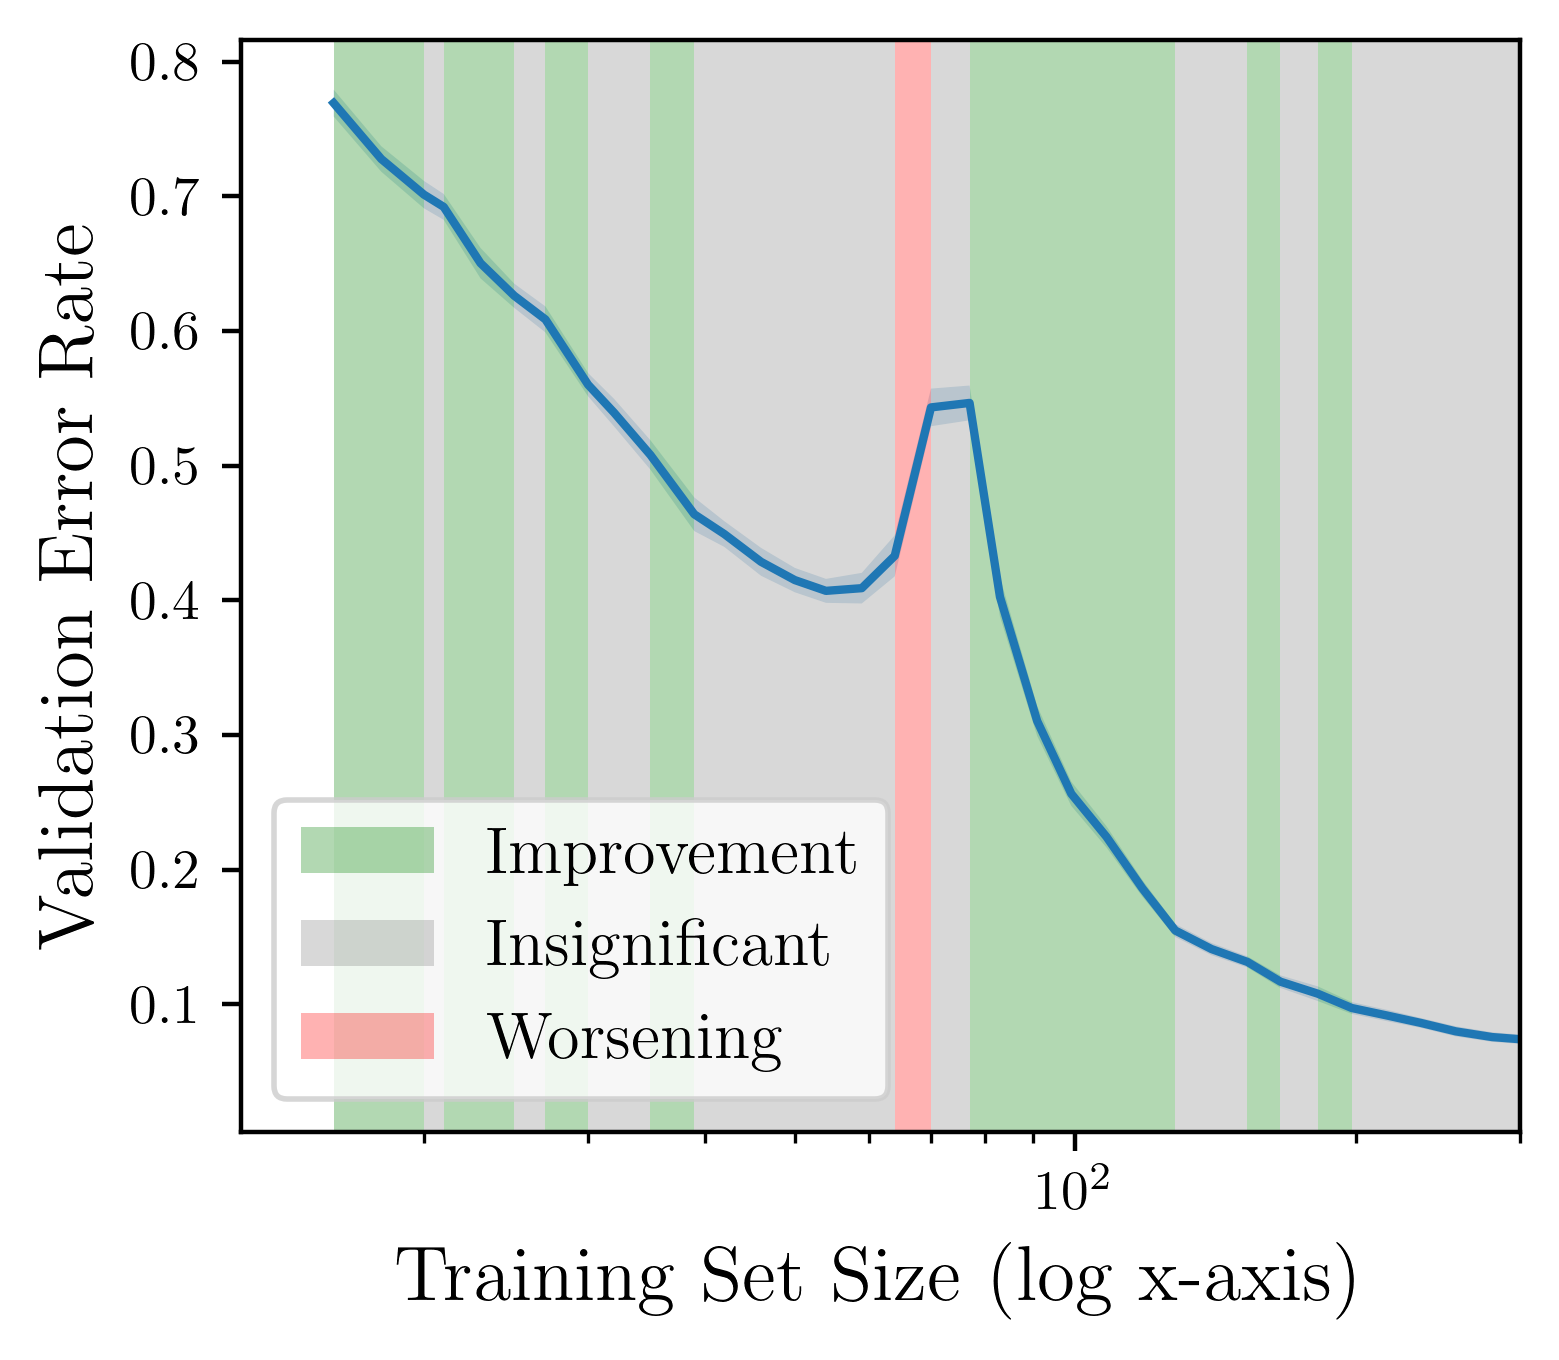

In [3]:
LEARNER = 12
DATASET = 6


print(f"learner: {LEARNER}, dataset: {DATASET}")

monotonicity_list, anchor_list_clean, number_peaks = identify_local_mono(LEARNER, DATASET, dataset_nofs)

lc_clean = dataset_nofs[DATASET, LEARNER, :, :, :, 1]
mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
se_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean[:, :, :]), axis=(0, 1)))

plt.figure(figsize=(4, 3.5), dpi=400)
plt.plot(anchor_list_denser, mean_clean)
plt.fill_between(anchor_list_denser, mean_clean - se_clean, mean_clean + se_clean, alpha=0.2)

added_labels = set()
for i in range(len(monotonicity_list)-1):
    x_start = anchor_list_clean[i]
    x_end = anchor_list_clean[i + 1]
    colors = 'green' if monotonicity_list[i] == 1 else 'red' if monotonicity_list[i] == -1 else 'gray'
    labels = 'Improvement' if monotonicity_list[i] == 1 else 'Worsening' if monotonicity_list[i] == -1 else 'Insignificant'
    if labels not in added_labels:
        plt.axvspan(x_start, x_end, color=colors, alpha=0.3, linewidth=0, label=labels)
        added_labels.add(labels)
    else:
        plt.axvspan(x_start, x_end, color=colors, alpha=0.3, linewidth=0)

# plt.title(f'{learner_zoo[LEARNER]}, OpenML ID {dataset_ids_CC18[DATASET]}, noFS', fontsize=14)
plt.xlabel('Training Set Size (log x-axis)', fontsize=14)
plt.ylabel('Validation Error Rate', fontsize=14)
plt.xscale('log')
plt.xlim(0,300)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Percentage Bar-chart

In [4]:
peak_matrix_nofs = np.full((24, 72), np.nan) 
peak_matrix_minmaxfs = np.full((24, 72), np.nan) 
peak_matrix_standardfs = np.full((24, 72), np.nan) 

for LEARNER in range(24):
    for DATASET in range(72):
        # keep previous mask: 
        # if not np.isnan(peak_matrix_nofs[LEARNER, DATASET]):
        #     continue
        # if not np.isnan(peak_matrix_minmaxfs[LEARNER, DATASET]):
        #     continue
        # if not np.isnan(peak_matrix_standardfs[LEARNER, DATASET]):
        #     continue   
        _, _, number_peaks_nofs = identify_local_mono(LEARNER, DATASET, dataset_nofs)
        peak_matrix_nofs[LEARNER, DATASET] = number_peaks_nofs

        _, _, number_peaks_minmaxfs = identify_local_mono(LEARNER, DATASET, dataset_minmaxfs)
        peak_matrix_minmaxfs[LEARNER, DATASET] = number_peaks_minmaxfs

        _, _, number_peaks_standardfs = identify_local_mono(LEARNER, DATASET, dataset_standardfs)
        peak_matrix_standardfs[LEARNER, DATASET] = number_peaks_standardfs


Not a curve in learner 15 dataset 0
Not a curve in learner 15 dataset 1
Not a curve in learner 15 dataset 2
Not a curve in learner 15 dataset 3
Not a curve in learner 15 dataset 4
Not a curve in learner 15 dataset 5
Not a curve in learner 15 dataset 6
Not a curve in learner 15 dataset 6
Not a curve in learner 15 dataset 7
Not a curve in learner 15 dataset 8
Not a curve in learner 15 dataset 9
Not a curve in learner 15 dataset 10
Not a curve in learner 15 dataset 11
Not a curve in learner 15 dataset 12
Not a curve in learner 15 dataset 13
Not a curve in learner 15 dataset 14
Not a curve in learner 15 dataset 15
Not a curve in learner 15 dataset 16
Not a curve in learner 15 dataset 17
Not a curve in learner 15 dataset 18
Not a curve in learner 15 dataset 19
Not a curve in learner 15 dataset 20
Not a curve in learner 15 dataset 21
Not a curve in learner 15 dataset 21
Not a curve in learner 15 dataset 22
Not a curve in learner 15 dataset 22
Not a curve in learner 15 dataset 23
Not a curve 

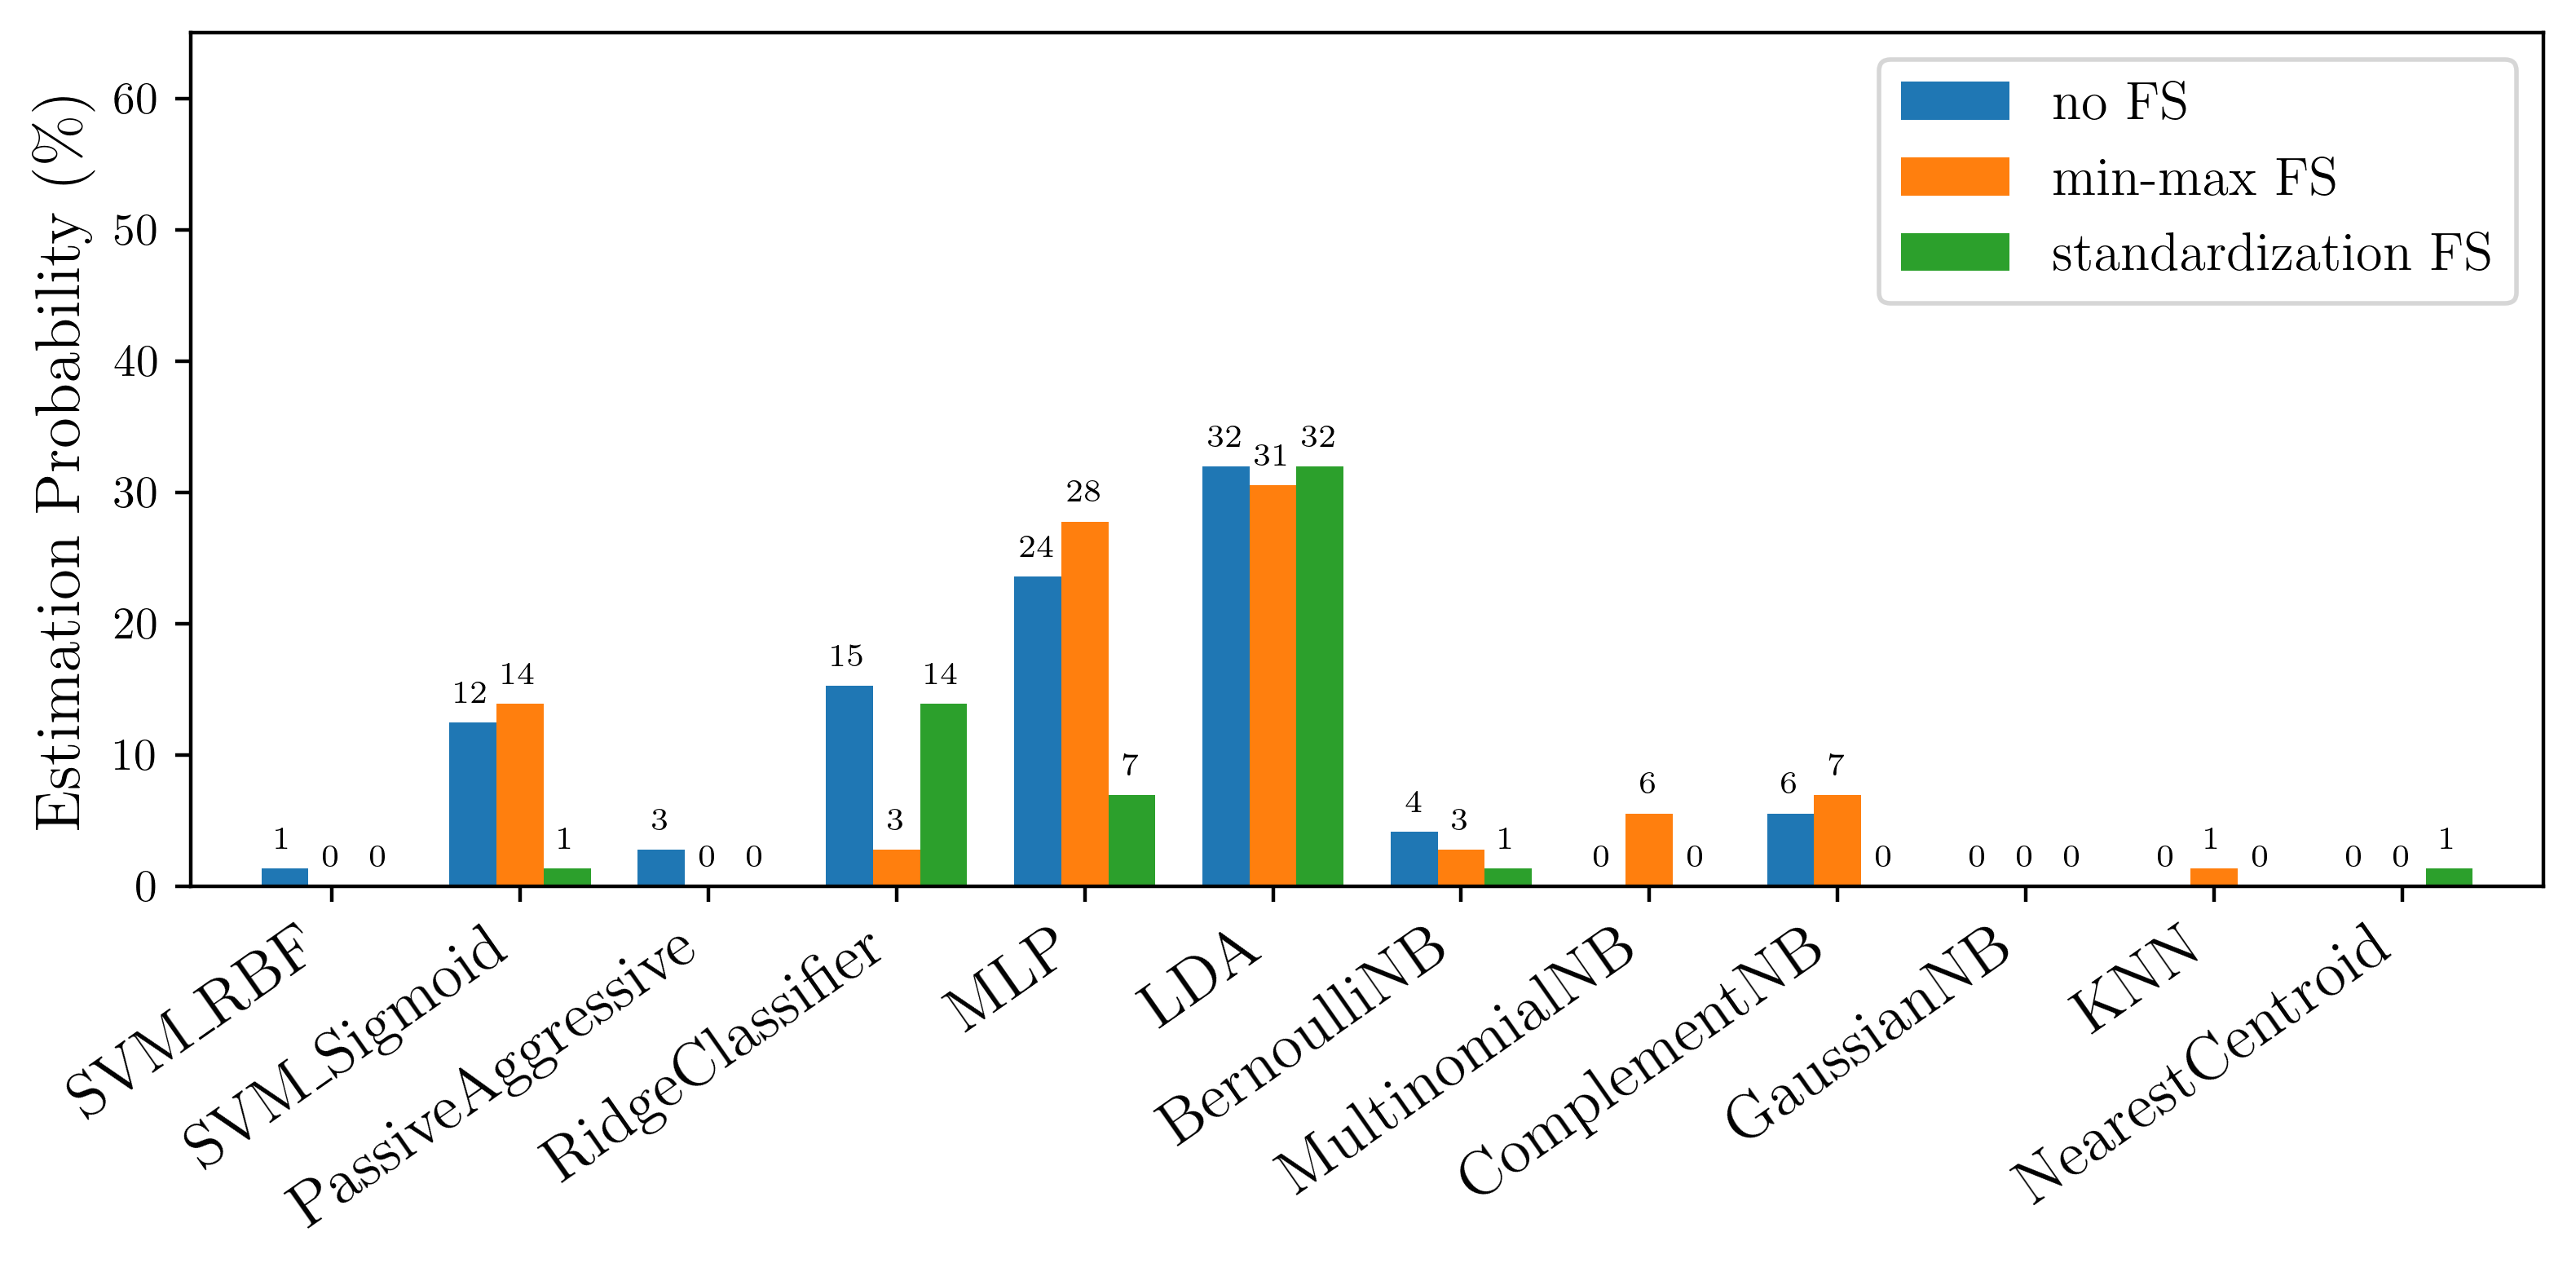

In [5]:
percentages_nofs = (np.sum(peak_matrix_nofs > 0, axis=1) / peak_matrix_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(peak_matrix_minmaxfs > 0, axis=1) / peak_matrix_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(peak_matrix_standardfs > 0, axis=1) / peak_matrix_standardfs.shape[1]) * 100

# filter some learner
exclude_indices = [0, 1, 4, 5, 6, 8, 10, 13, 20, 21, 22 ,23]         # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

fig, ax = plt.subplots(figsize=(8, 4), dpi=400)     # (11, 5)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Estimation Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=35, ha='right', fontsize = 14)  
ax.legend(fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


### Position Range of Local Mono Violation

##### MLP

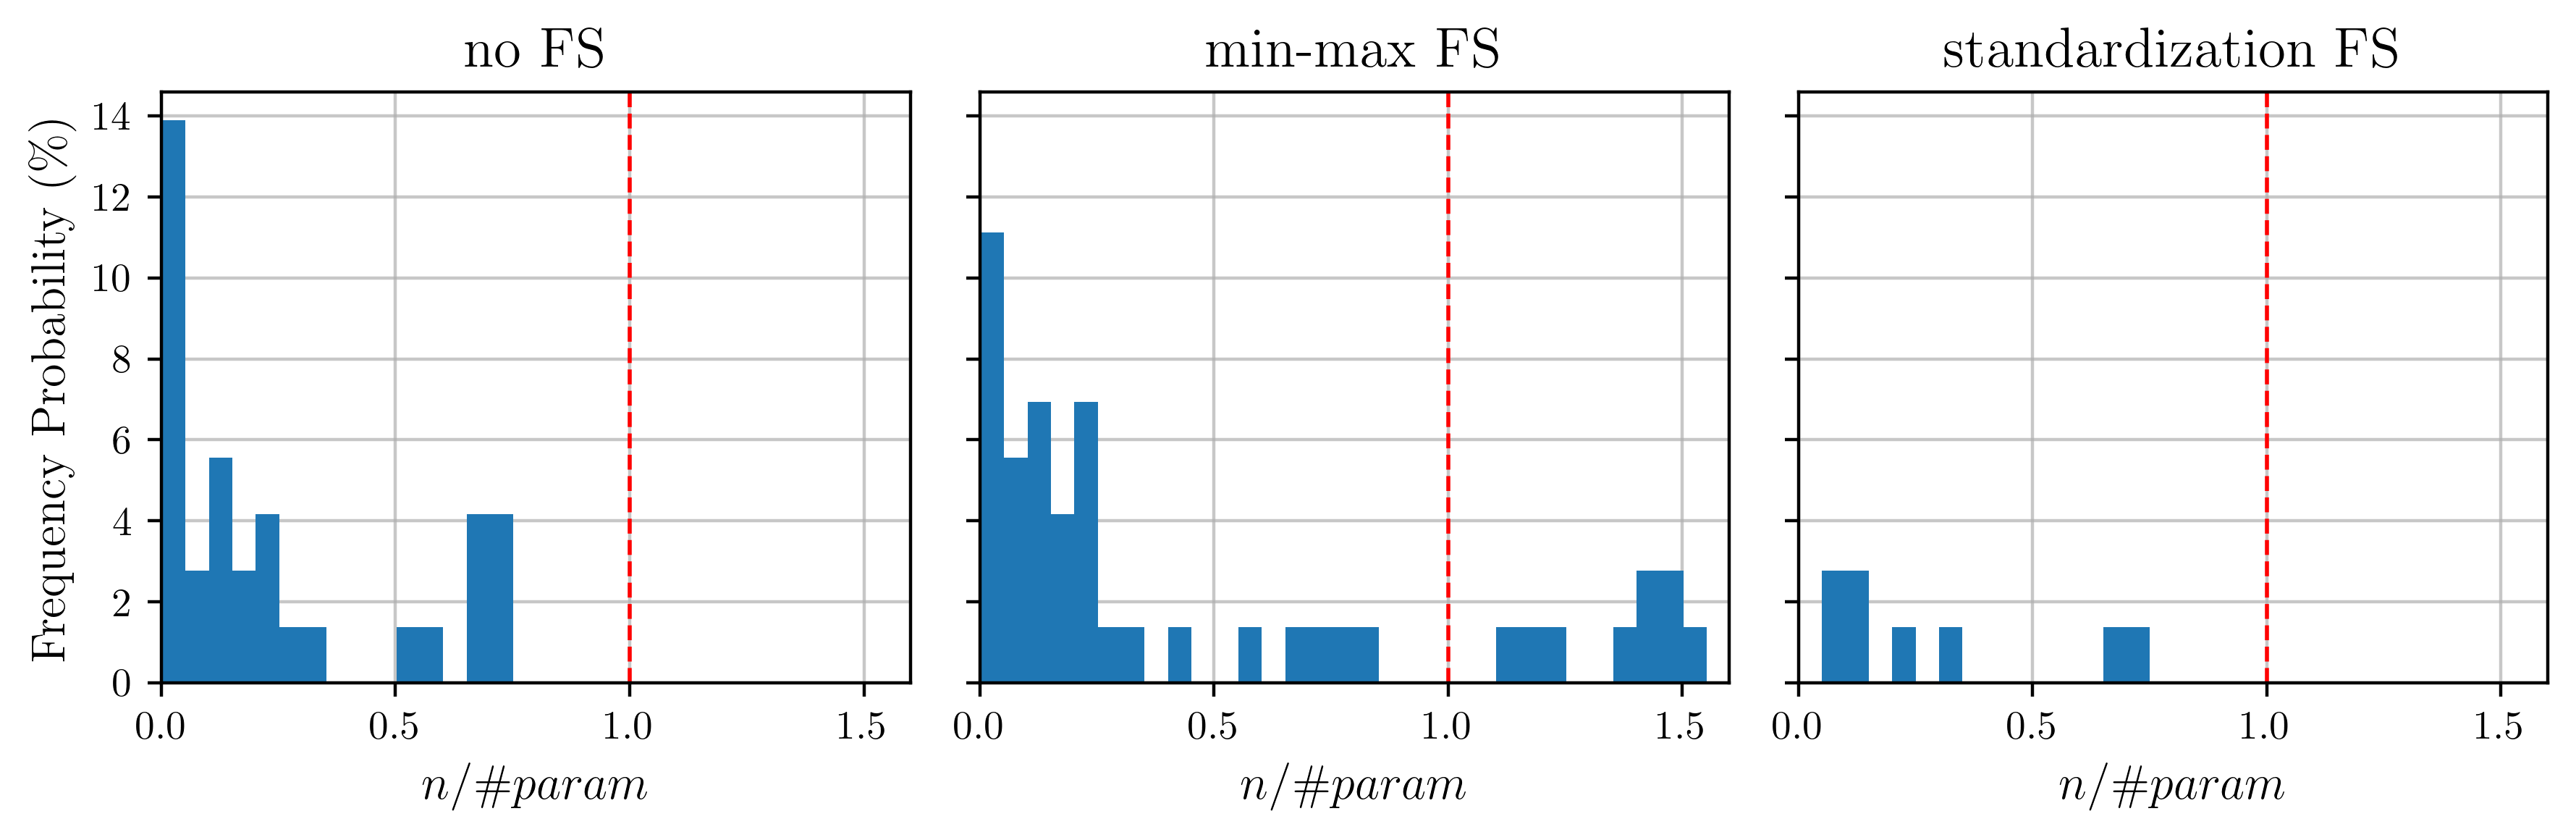

In [10]:
LEARNER = 11
bin_width = 0.05 

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (dataset, ax, title) in enumerate(zip(
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):
    # store ratios for histogram plotting
    ratios = []  
    for data_idx in range(dataset_nofs.shape[0]):

        monotonicity_list, anchor_list_clean, number_peaks = identify_local_mono(LEARNER, data_idx, dataset)
        mono_viola_anchor = np.where(np.array(monotonicity_list) == -1)[0].tolist()
        for anchor in mono_viola_anchor:
            start = anchor_list_clean[anchor]
            end = anchor_list_clean[anchor+1]
            
            ###### ideal peak position
            ideal_peak = (feature_num_CC18[data_idx] + 1) * 100 + class_num_CC18[data_idx] * (100 + 1)
            
            start_ratio = start / ideal_peak
            end_ratio = end / ideal_peak

            # record all ratios from start to end (inclusive)
            ratios.extend(np.arange(start_ratio, end_ratio, bin_width).tolist())

    bins = np.arange(min(ratios), max(ratios) + bin_width, bin_width)
    n, bins, patches = ax.hist(ratios, bins=bins, density=False)
    n = (n / dataset_nofs.shape[0]) * 100 # convert into %
    ax.cla()  
    ax.bar(bins[:-1], n, width=bin_width, align='edge')
    ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('$n/\\#param$', fontsize=12)
    ax.set_xlim(0, 1.6)
    ax.set_title(title, fontsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # grid bottom
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.7)
axes[0].set_ylabel(r'Frequency Probability (\%)', fontsize=12)

plt.tight_layout()
plt.show()

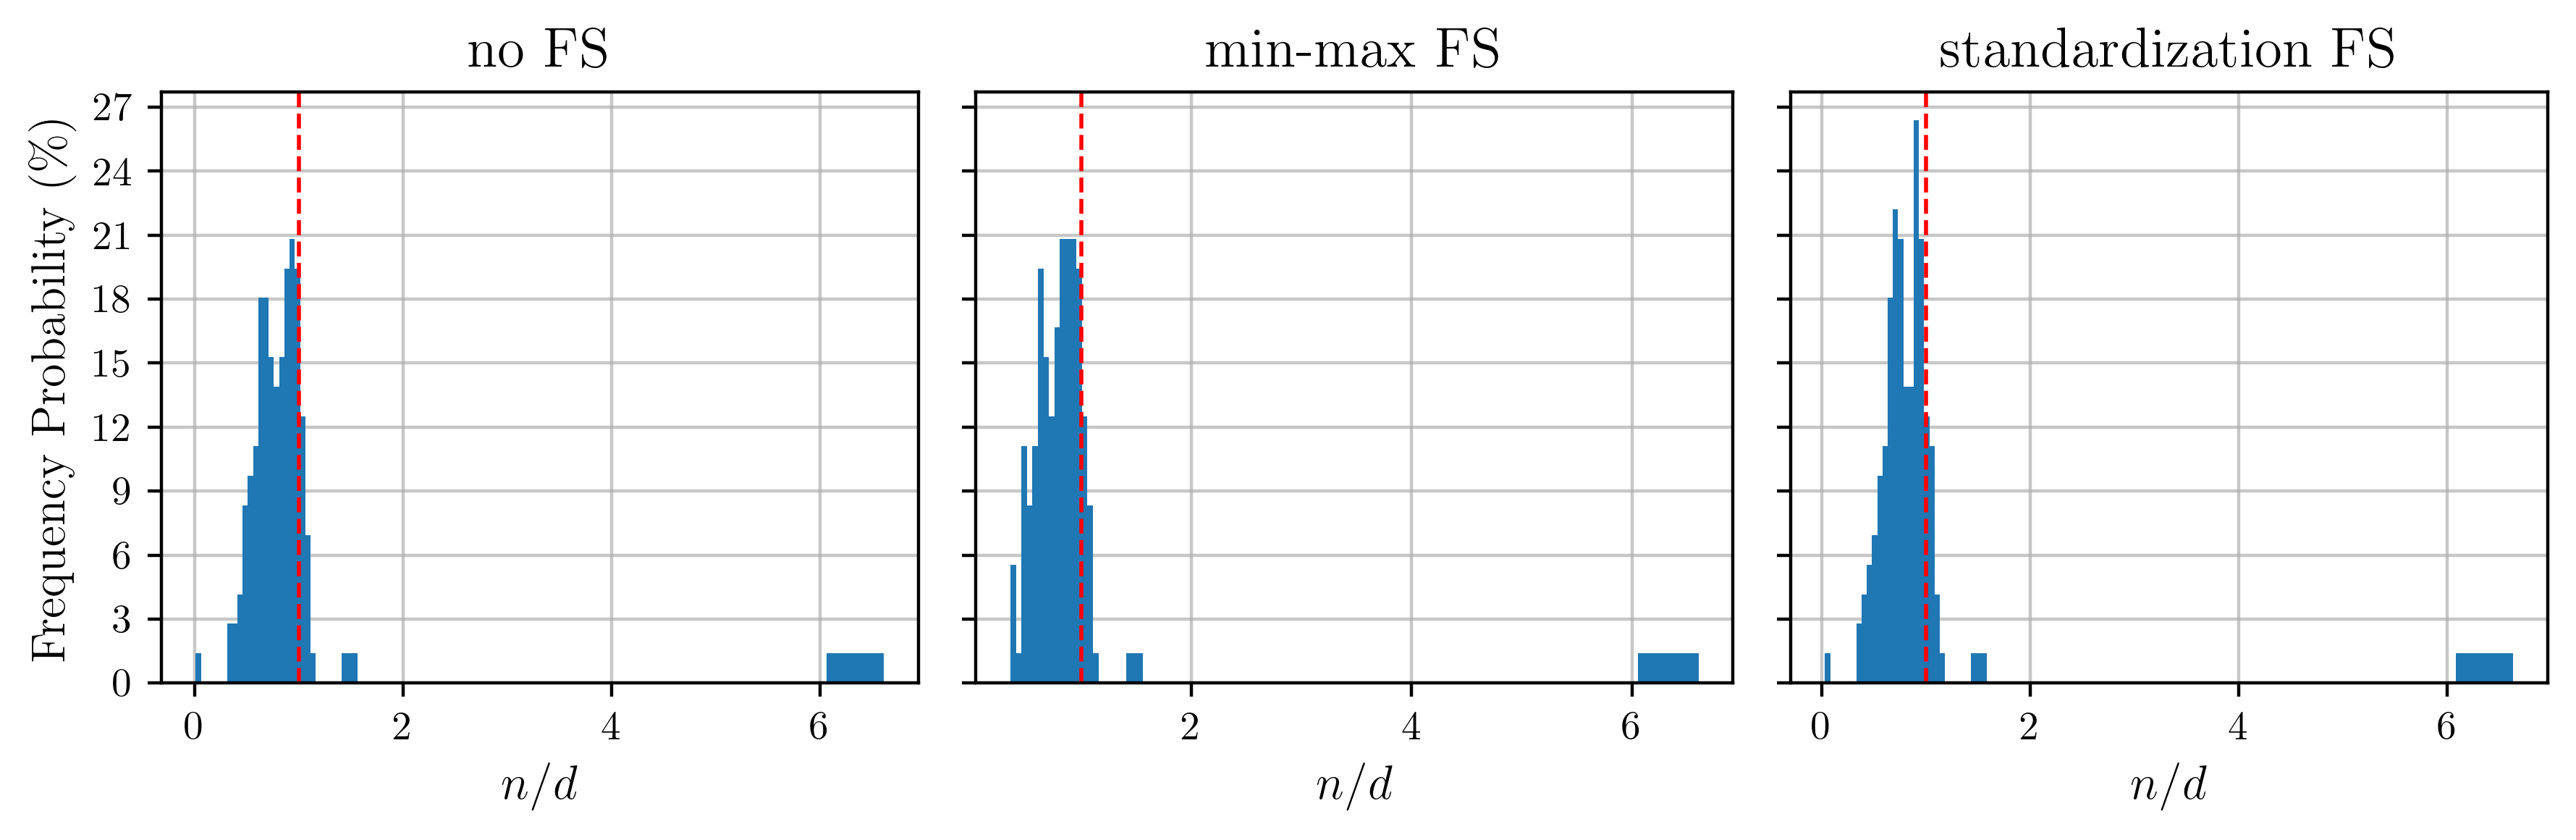

In [11]:
LEARNER = 12
bin_width = 0.05 

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (dataset, ax, title) in enumerate(zip(
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):
    # store ratios for histogram plotting
    ratios = []  
    for data_idx in range(dataset_nofs.shape[0]):

        monotonicity_list, anchor_list_clean, number_peaks = identify_local_mono(LEARNER, data_idx, dataset)
        mono_viola_anchor = np.where(np.array(monotonicity_list) == -1)[0].tolist()
        for anchor in mono_viola_anchor:
            start = anchor_list_clean[anchor]
            end = anchor_list_clean[anchor+1]
            
            ###### ideal peak position
            ideal_peak = feature_num_CC18[data_idx]
            
            start_ratio = start / ideal_peak
            end_ratio = end / ideal_peak

            # record all ratios from start to end (inclusive)
            ratios.extend(np.arange(start_ratio, end_ratio, bin_width).tolist())

    bins = np.arange(min(ratios), max(ratios) + bin_width, bin_width)
    n, bins, patches = ax.hist(ratios, bins=bins, density=False)
    n = (n / dataset_nofs.shape[0]) * 100 # convert into %
    ax.cla()  
    ax.bar(bins[:-1], n, width=bin_width, align='edge')
    ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('$n/d$', fontsize=12)
    # ax.set_ylim(0, 11)
    ax.set_title(title, fontsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # grid bottom
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.7)
axes[0].set_ylabel(r'Frequency Probability (\%)', fontsize=12)

plt.tight_layout()
plt.show()